In [20]:
import sys
sys.path.append("../../")

from scipy.interpolate import CubicSpline
import math
import numpy as np
import matplotlib.pyplot as plt

from didgelab.evo.nuevolution import GeoGenome
from didgelab.calc.geo import Geo, geotools
from didgelab.util.didge_visualizer import vis_didge
from didgelab.calc.sim.sim import compute_impedance_iteratively, get_notes, compute_impedance, create_segments, get_log_simulation_frequencies

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, SplineTransformer
from sklearn.linear_model import Ridge

(1657.0425952294834, 108.06081812479576)


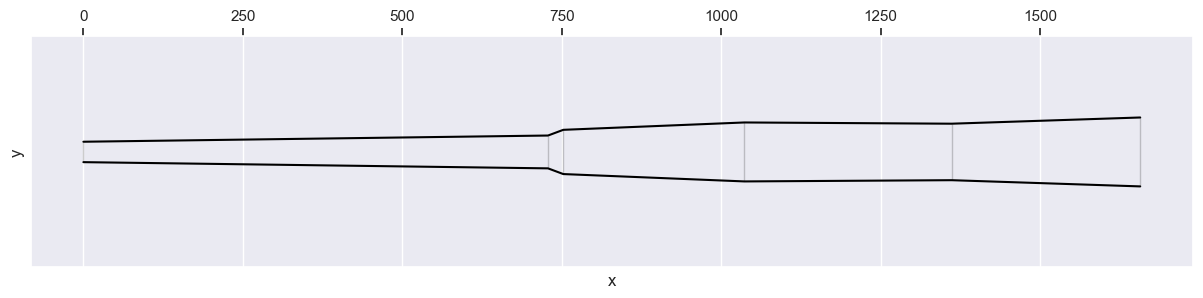

1719.52540157093 71.45568099117258
(1657.0425952294834, 114.41243421289997)


/var/folders/x2/b40hstxn35z830rfs3b1ncrc0000gp/T/ipykernel_62031/3237586484.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.genome = np.array(genome)
/var/folders/x2/b40hstxn35z830rfs3b1ncrc0000gp/T/ipykernel_62031/3237586484.py:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_genome = np.array([self.genome[i] for i in range(2, len(self.genome), 2)])


TypeError: unhashable type: 'numpy.ndarray'

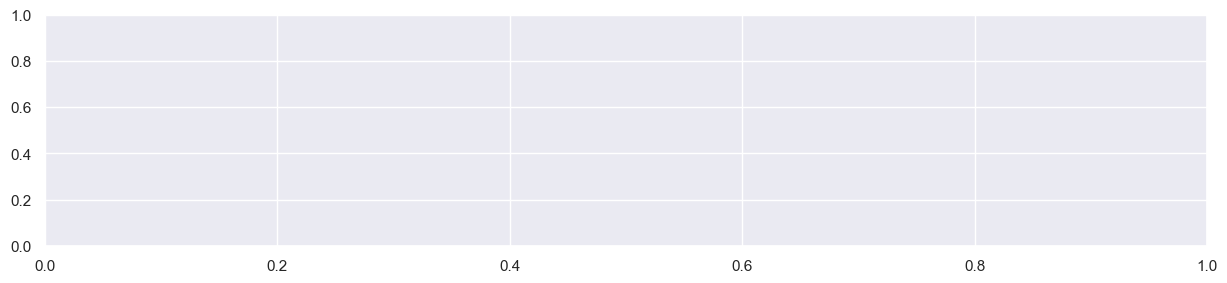

In [17]:
class SplineShape(GeoGenome):

    def __init__(
        self,
        init_resolution = 5, 
        d0=32, 
        d_bell_min=50, 
        d_bell_max=80,
        max_length = 1900, 
        min_length = 1500):

        self.max_length = max_length
        self.min_length = min_length
        self.resolution = init_resolution
        self.init_resolution = init_resolution
        self.d0 = 32
        self.d_bell_min = d_bell_min
        self.d_bell_max = d_bell_max

        GeoGenome.__init__(self, n_genes = 2+2*init_resolution)

    # def double_resolution(self):
    #     x = np.concatenate(([0], [self.genome[i] for i in range(2, len(self.genome), 2)]))
    #     x = np.concatenate(([0], [x[i]+x[i-1] for i in range(1, len(x))]))
    #     print(x)
    #     y = np.concatenate(([0], [self.genome[i] for i in range(3, len(self.genome), 2)]))
    #     cs = CubicSpline(x, y)
    #     x_new = [(x[i-1] + x[i])/2 for i in range(1, len(x))]
    #     x_int = np.sort(np.concatenate((x, x_new)))
    #     y_int  = cs(x_int)

    #     self.genome = np.concatenate((self.genome[0:2], list(zip(x_int, y_int))))

    def get_properties(self):
        length = self.genome[0] * (self.max_length-self.min_length) + self.min_length
        bell_size = self.genome[1] * (self.d_bell_max - self.d_bell_min) + self.d_bell_min

        x_genome = np.array([self.genome[i] for i in range(2, len(self.genome), 2)])
        y_genome = np.array([self.genome[i] for i in range(3, len(self.genome), 2)])

        return length, bell_size, x_genome, y_genome

    def genome2geo(self):
        length, bell_size, x_genome, y_genome = self.get_properties()
        x = np.concatenate(([0], x_genome))
        x *= length
        x = sorted(x)

        a = (bell_size-self.d0)/length
        y = np.arange(len(y_genome))/len(y_genome) + 0.5*y_genome
        y = self.d0 + y*bell_size
        y = np.concatenate(([self.d0], y))

        shape = list(zip(x,y))
        geo=Geo(shape)

        return geo

    def double_resolution(self):

        length, bell_size, x_genome_alt, y_genome_alt = self.get_properties()
        print(length, bell_size)
        n = len(x_genome_alt)
        x = np.concatenate(([0], x_genome_alt))
        x *= length
        x = sorted(x)
        x = np.array(x)
        
        a = (bell_size-self.d0)/length
        y = np.arange(n)/n + 0.5*y_genome_alt
        y = np.concatenate(([0], y))

        #cs = CubicSpline(x, y)
        model = make_pipeline(SplineTransformer(n_knots=4, degree=3), Ridge(alpha=1e-3))
        model.fit(x.reshape((-1,1)),y.reshape((-1,1)))
        x_int = [(x[i-1] + x[i])/2 for i in range(1, len(x))]
        x_int = np.array(x_int).reshape((-1,1))
        #y_int  = cs(x_int)
        y_int = model.predict(x_int).reshape(-1)

        x_new = np.array(x_int[1:])/length
        x_genome_final = []
        y_genome_final = []

        genome = list(self.genome[0:2])
        for i in range(n):
            genome.append(x_genome_alt[i])
            genome.append(y_genome_alt[i])

            if i+1<len(y_int):
                genome.append(x_new[i])
                genome.append(y_int[i])

        self.genome = np.array(genome)

np.random.seed(0)

def mini_report(geo):
    print(geo.geo[-1])
    vis_didge(geo)
    plt.show()

didge = SplineShape(init_resolution=5)
geo = mini_report(didge.genome2geo())

didge.double_resolution()
mini_report(didge.genome2geo())

In [13]:
x=np.ones(5)
y=x.reshape((-1,1))
y.reshape(-1)

array([1., 1., 1., 1., 1.])

[118.47346151 152.37452026 153.47361964 168.56049724 200.        ]


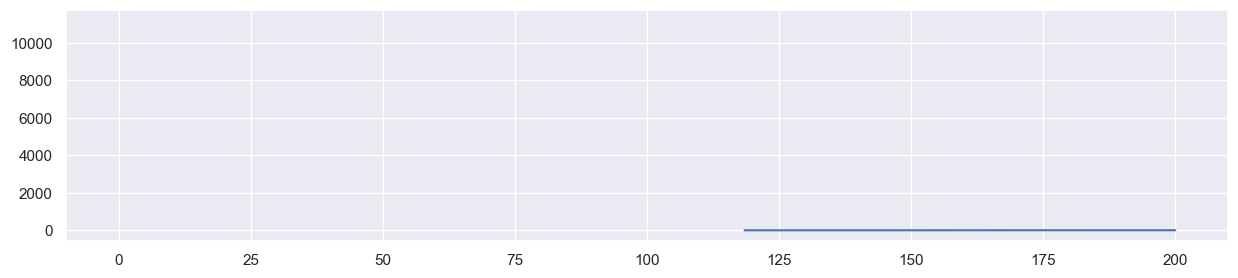

In [18]:
n=5

bell_size=50
length=200

np.random.seed(0)
x = np.random.sample(n)
y = np.arange(n) + np.random.sample(n)

x = np.sort(x)
x = length*x/x[-1]

cs = CubicSpline(x, y)

x_int = [(x[i-1] + x[i])/2 for i in range(1, len(x))]
y_int  = cs(x_int)

x2 = [x[0]]
y2 = [y[0]]
for i in range(len(x_int)):
    x2.append(x[i+1])
    x2.append(x_int[i])
    y2.append(y[i+1])
    y2.append(y_int[i])

shape2 = list(zip(x2,y2))
shape2 = sorted(shape2, key=lambda x:x[0])
x2 = [x[0] for x in shape2]
y2 = [x[1] for x in shape2]

x3 = np.arange(0,1,100)*length
y3 = cs(x3)

print(x)

plt.plot(x,y)
plt.plot(x3,y3)


(963.6627605010293, 69.35152404559283)


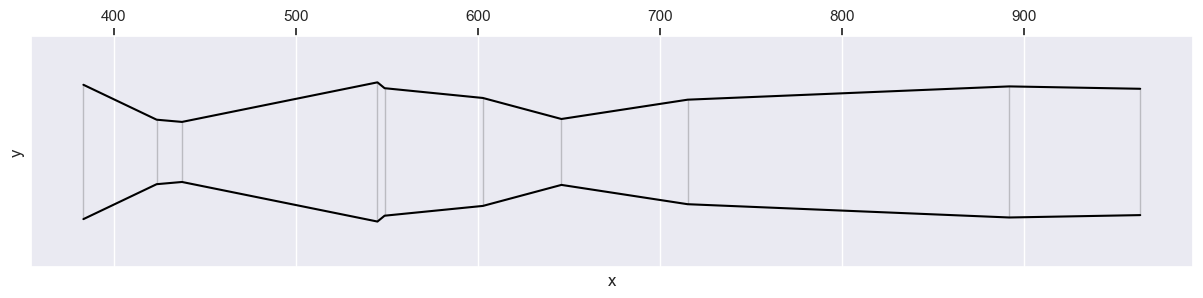

[50.67112662 33.1762611  77.82480192 73.19790201 54.98354534 49.07598238
 39.04942825 78.30358954 69.10080339]
[963.6627605010293, 69.35152404559283]


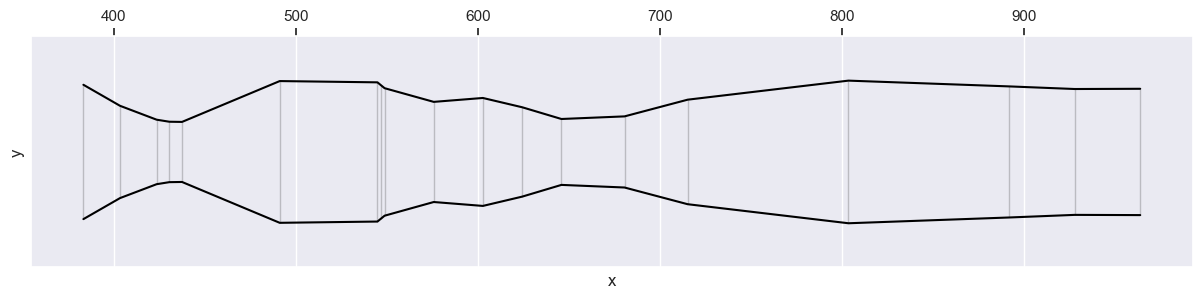

In [19]:
def mini_report(geo):
    print(geo.geo[-1])
    vis_didge(geo)
    plt.show()

length = 1000
bell_size=80
d0=32
n=10

def genome2geo(x,y):

    _x = x*length
    _y = y*(bell_size-d0)+d0

    shape = list(zip(_x,_y))
    shape = sorted(shape, key=lambda x:x[0])

    return Geo(shape)


np.random.seed(0)
x=np.random.uniform(0, 1, n)
y=np.random.uniform(0, 1, n)
geo = genome2geo(x,y)

def smooth_geo(geo):
    x=[g[0] for g in geo.geo]
    y=[g[1] for g in geo.geo]

    cs = CubicSpline(x, y)

    x_int = [(x[i-1] + x[i])/2 for i in range(1, len(x))]
    y_int  = cs(x_int)
    print(y_int)

    x = np.concatenate((x,x_int))
    y = np.concatenate((y,y_int))
    shape = [[x[i],y[i]] for i in range(len(x))]
    shape = sorted(shape, key=lambda x:x[0])
    shape = Geo(shape)
    return shape
    

#geo = [[0,32], [500, 35], [1000, 40], [1200, 50], [1300, 80], [1400, 60], [1500, 75]]
#geo = Geo(geo)
geo = genome2geo(x,y)
mini_report(geo)

geo2 = smooth_geo(geo)
mini_report(geo2)

In [108]:
np.random.seed(0)
n=5
gx = np.random.sample(n)
x = np.arange(len(gx)) + gx
print(gx)
print(x)
print(x-np.arange(len(gx)))

[0.5488135  0.71518937 0.60276338 0.54488318 0.4236548 ]
[0.5488135  1.71518937 2.60276338 3.54488318 4.4236548 ]
[0.5488135  0.71518937 0.60276338 0.54488318 0.4236548 ]


In [106]:
bell_size=80
d0=32
length=1500

a = (bell_size-d0)/length
gy = np.random.sample(n)
y = np.arange(n)/n + 0.5*gy
y = d0 + y*bell_size

print(gy)

y_orig = y.copy() - d0
y_orig /= bell_size
y_orig -= np.arange(n)/n
y_orig += 0.5*gy
print(y_orig)

[0.0871293  0.0202184  0.83261985 0.77815675 0.87001215]
[0.0871293  0.0202184  0.83261985 0.77815675 0.87001215]


In [89]:
x_alt = np.array([didge.genome[i] for i in range(2, len(didge.genome), 2)])
length, bell_size, x, y, x_genome, y_genome = didge.compute()

cs = CubicSpline(x, y)

x_new = x_new[1:]

x_new = x_new/length
print(x_alt)

print(x_new)

#x_int = np.sort(np.concatenate((x, x_new)))
#y_int  = cs(x_int)
#a = (bell_size-didge.d0)/length


[0.60276338 0.4236548  0.43758721 0.96366276 0.79172504]
[0.00022023 0.00022786 0.00030602 0.0005713  0.00058156]


array([   0.        ,  210.07024874,  483.82446036,  714.54519051,
        923.11102383, 1085.2740691 , 1332.50402248, 1500.        ])

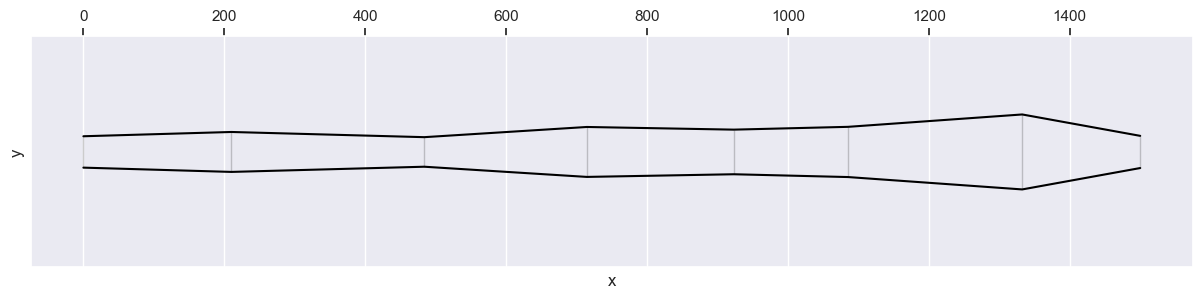

In [47]:
np.random.seed(0)

init_resolution = 8

length = 1500
d0 = 32
bell = 80

x = np.zeros(init_resolution)
for i in range(1, init_resolution):
    x[i] = x[i-1] + np.random.sample()
x = length*x/x[-1]

a = (bell-d0)/length
y = np.array([d0 + a*_x for _x in x])

diff = np.random.uniform(0.5, 1.5, size=init_resolution)
y *= diff

geo = list(zip(x,y))
geo=Geo(geo)
DidgeVisualizer.vis_didge(geo)
x

<AxesSubplot: xlabel='x', ylabel='y'>

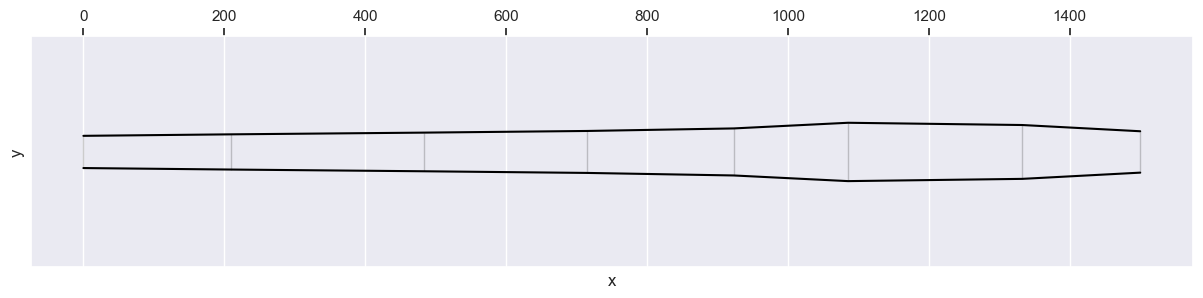

In [46]:
from scipy.signal import savgol_filter
y2 = savgol_filter(y, 5, 2)
geo = list(zip(x,y2))
geo=Geo(geo)
DidgeVisualizer.vis_didge(geo)


/Users/jane03/miniconda3/envs/didge/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3442: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


(0.0, 200.0)

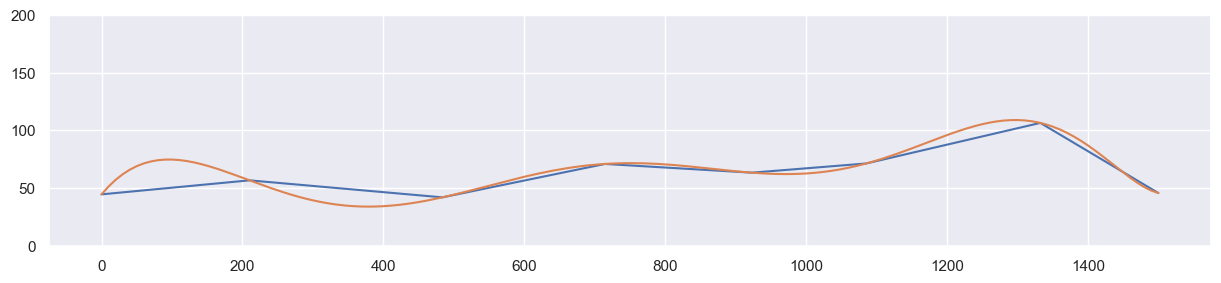

In [65]:
import matplotlib.pyplot as plt
plt.plot(x, y)
poly = np.polyfit(x, y, deg=10)
x_val = np.arange(0, x[-1]*2, 10)
y_int  = np.polyval(poly, x_val)

y_int = y_int[x_val<=x[-1]]
x_val = x_val[x_val<=x[-1]]

plt.plot(x_val, y_int)
plt.ylim([0, 200])


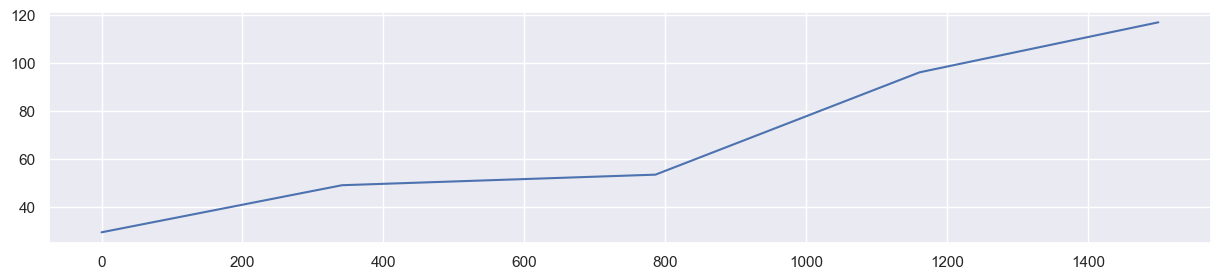

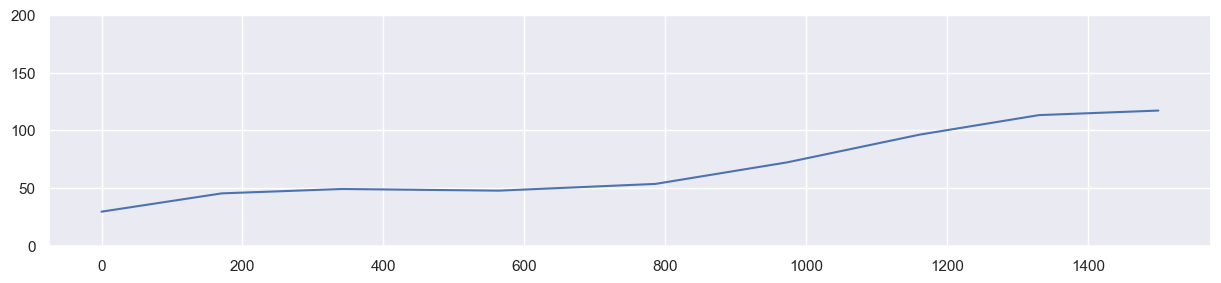

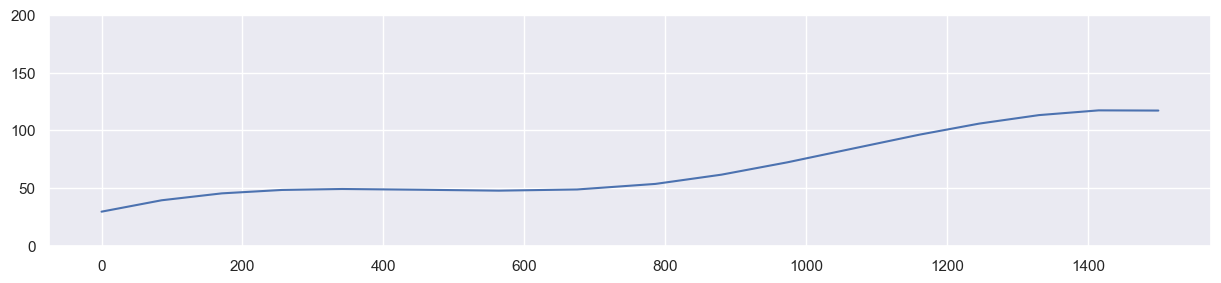

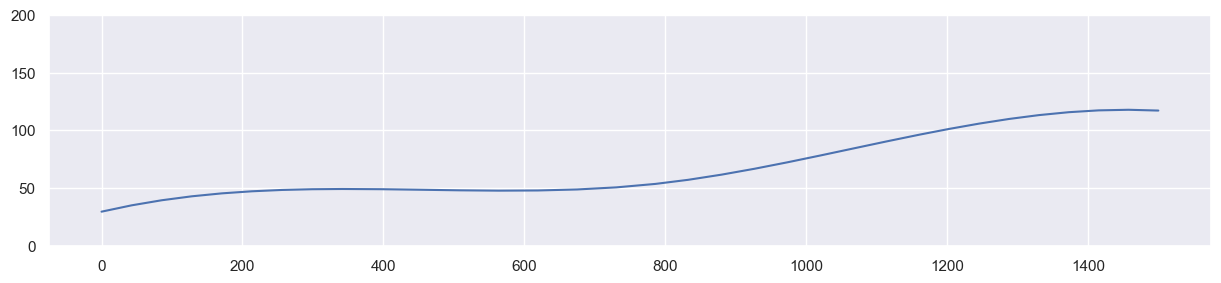

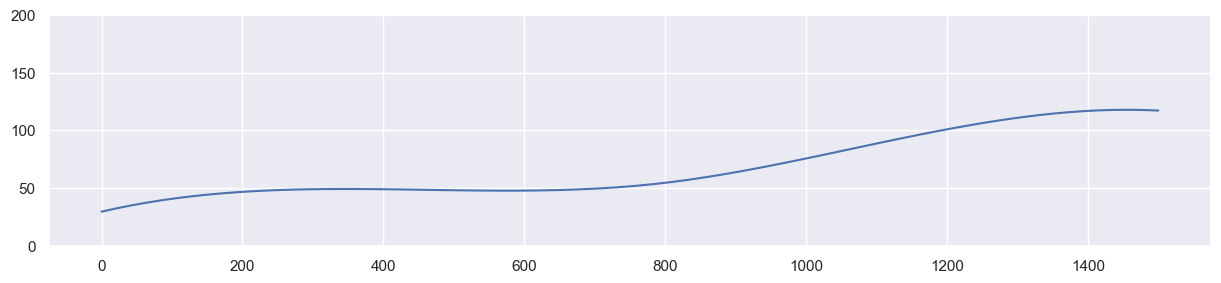

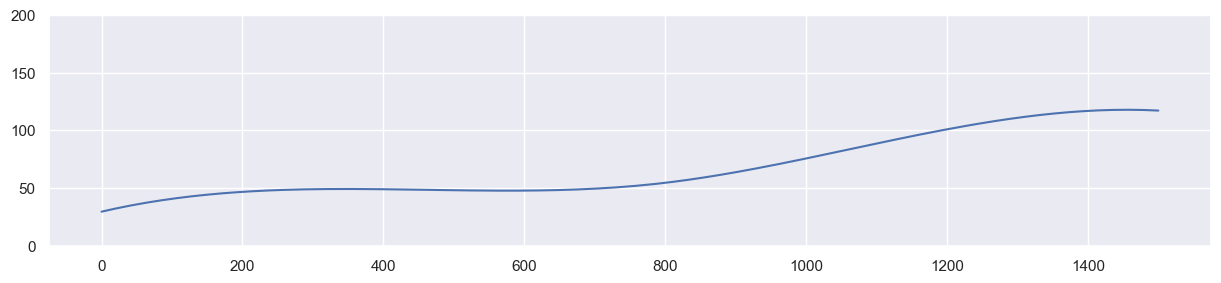

In [79]:
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

np.random.seed(0)

init_resolution = 5
x = np.zeros(init_resolution)
for i in range(1, init_resolution):
    x[i] = x[i-1] + np.random.sample()
x = length*x/x[-1]

a = (bell-d0)/length
y = np.array([d0 + a*_x for _x in x])

diff = np.random.uniform(0.5, 1.5, size=init_resolution)
y *= diff

def double_resolution(x, y):
    cs = CubicSpline(x, y)
    x_new = [(x[i-1] + x[i])/2 for i in range(1, len(x))]
    x_int = np.sort(np.concatenate((x, x_new)))
    y_int  = cs(x_int)
    return x_int, y_int

plt.plot(x, y)
plt.show()
plt.ylim([0, 200])
for i in range(5):
    x,y = double_resolution(x,y)
    plt.plot(x, y)
    plt.ylim([0, 200])
    plt.show()


[(0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0)]